In [7]:
import tensorflow as tf
import sys
sys.path.append('/workspace/detect-me/product_classifier/scripts')
from utils import data_loader
from pathlib import Path
from keras.applications.resnet import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densnet
import kerastuner as kt

In [5]:
# base_model = efficientNetB7 = tf.keras.applications.EfficientNetB7(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )
# len(base_model.layers)

In [6]:

# base_model = tf.keras.applications.ResNet152V2(
#                         include_top=False,
#                         weights="imagenet",
#                         input_tensor=None,
#                         input_shape=None,
#                         pooling=None,
#                         classes=1000,
# #                         classifier_activation="softmax",
# )

In [7]:
# base_model = tf.keras.applications.ResNet50(
#                              include_top=False,
#                              weights="imagenet",
#                              input_tensor=None,
#                              # input_shape=(*self.image_size, 3),
#                              pooling=None,
#                              classes=1000)

In [2]:
base_model = tf.keras.applications.DenseNet121(
                            include_top=False,
                            weights="imagenet",
                            input_tensor=None,
                            input_shape=None,
                            pooling=None,
                            classes=1000,
                        )

In [8]:
# base_model = tf.keras.applications.ResNet50V2(
#                              include_top=False,
#                              weights="imagenet",
#                              input_tensor=None,
#                              # input_shape=(*self.image_size, 3),
#                              pooling=None,
#                              classes=1000)

In [3]:
path_to_data = Path('/workspace/detect-me/product_classifier/data/milk')

In [4]:
dropout = 0.5
batch_size = 16
fine_tune_at = 80

In [5]:
dataset =  data_loader.load_data_flow_from_dataframe(
            path_to_data / 'train-val',
            path_to_data / 'test',
            target_image_size=(224,224),
            batch_size=batch_size
)
num_classes = len(dataset['train'].class_indices)

len classes_set 339
load_with OUT_mixup_generator
Found 10113 validated image filenames belonging to 339 classes.
Found 2632 validated image filenames belonging to 339 classes.
Found 718 validated image filenames belonging to 339 classes.


In [8]:
def build(hp):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    # x = self.data_augment(inputs)
#     x = preprocess_input_resnet(inputs)
    x = preprocess_input_densnet(inputs)
#     x = preprocess_input_efficientnet(inputs)
    # As previously mentioned, use training=False as our model contains a BatchNormalization layer.
    x = base_model(x, training=False)
# __________________________________________________________________________    
    
    if hp.Choice('global_pooling', ['max', 'avg']) == 'max':
        x = tf.keras.layers.GlobalMaxPooling2D()(x)
    else:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#     x = global_average_layer(x)
# __________________________________________________________________________
    x = tf.keras.layers.Dropout(
            hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
# __________________________________________________________________________
    x = tf.keras.layers.Dense(
          hp.Int('hidden_size', 512, 1536, step=512, default=num_classes//2),
            activation='relu')(x)

#     x = tf.keras.layers.Dense(1000, activation='relu')(x)
#     x = tf.keras.layers.Dense(num_classes//2, activation='relu')(x)
# __________________________________________________________________________
    
    prediction_layer = tf.keras.layers.Dense(
        num_classes, activation='softmax')

    outputs = prediction_layer(x)

    model = tf.keras.Model(inputs, outputs)

    base_model.trainable = True

#     for layer in base_model.layers[:hp.Choice('fine_tune', [200, 120, 100, 70,80,60, 50, 30, 0])]:
    for layer in base_model.layers[:hp.Choice('fine_tune', [20, 40, 50, 70, 100, 400,])]:
        layer.trainable = False

    print('len(self.model.trainable_variables) ',
          len(base_model.trainable_variables))

    optimizer=tf.keras.optimizers.Adam(lr=hp.Float('learning_rate', 1e-6, 1e-2, sampling='log'),
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=0.1,
#                                     epsilon=hp.Float('epsilon_adam', 1e-2, 1, sampling='log'),
                                    amsgrad=False,
                                    name="Adam",)
#     optimizer=tf.keras.optimizers.SGD(lr=hp.Float('learning_rate', 1e-6, 1e-2, sampling='log'),
#                                     momentum=0.9,
#                                      name="SGD")

    model.compile(optimizer=optimizer,
#                        loss='categorical_crossentropy',
                    loss=tf.nn.softmax_cross_entropy_with_logits,
                       metrics=['accuracy',
                                #                       tf.keras.metrics.AUC(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),
                                # tfa.metrics.F1Score(num_classes=num_classes),
                                #   tf.keras.metrics.SparseCategoricalCrossentropy() #error
                                ],)        
    return model

In [38]:
# def get_tuning_model(num_classes, input_shape):
#     model = HyperResNet(input_shape=input_shape, classes=num_classes)
#     return model

In [9]:
project = 'DENSENET'
hyperband_tuner = kt.Hyperband(
    build,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=2,
    directory=project,
#     max_trials=50,
    project_name=f'{project}-2')

len(self.model.trainable_variables)  347


In [ ]:
tuner_result =\
    hyperband_tuner.search(dataset['train'],
             validation_data=dataset['validation'],
             epochs=15,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Trial 21 Complete [00h 13m 48s]
val_accuracy: 0.12765957415103912

Best val_accuracy So Far: 0.12765957415103912
Total elapsed time: 03h 07m 12s

Search: Running Trial #22

Hyperparameter    |Value             |Best Value So Far 
global_pooling    |avg               |avg               
dropout           |0.2               |0.2               
hidden_size       |1024              |512               
fine_tune         |40                |40                
learning_rate     |4.1266e-06        |0.0015882         
tuner/epochs      |7                 |7                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |1                 |1                 
tuner/round       |0                 |0                 

len(self.model.trainable_variables)  330
Epoch 1/7
633/633 [==============================] - 126s 185ms/step - loss: 5.8266 - accuracy: 0.0016 - precision: 9.6561e-04 - recall: 3.4730e-04 - val_loss: 5.8264 - val_accuracy: 0.0015 - val_precision: 0.0011 -

In [24]:
# project = 'resnet50_baysian'
# bayesian_tuner = kt.tuners.BayesianOptimization(
#   kt.applications.HyperResNet(include_top=False,input_shape=(224, 224, 3), classes=num_classes),
#   objective='val_accuracy',
#   directory=project,
#   project_name='1',
#   max_trials=50)

INFO:tensorflow:Reloading Oracle from existing project resnet50_hyperband/resnet50_hyperband-2/oracle.json
len(self.model.trainable_variables)  0
INFO:tensorflow:Reloading Tuner from resnet50_hyperband/resnet50_hyperband-2/tuner0.json


In [16]:
baysian_tuner0 = kt.tuners.BayesianOptimization(
    build,
    objective='val_accuracy',
    num_initial_points=50,
    max_trials=15,
    directory=project,
    project_name='2')

len(self.model.trainable_variables)  0


In [17]:
tuner_result =\
    hyperband_tuner.search(dataset['train'],
             validation_data=dataset['validation'],
             epochs=15,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
global_pooling    |avg               |?                 
dropout           |0.2               |?                 
hidden_size       |1024              |?                 
fine_tune         |500               |?                 
learning_rate     |0.0096763         |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |3                 |?                 
tuner/round       |0                 |?                 

len(self.model.trainable_variables)  0
Epoch 1/2


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  logits and labels must be broadcastable: logits_size=[16,9569] labels_size=[16,336]
	 [[node softmax_cross_entropy_with_logits_v2/softmax_cross_entropy_with_logits (defined at /workspace/venv/lib/python3.8/site-packages/kerastuner/engine/tuner.py:141) ]]
	 [[assert_greater_equal/Assert/AssertGuard/pivot_f/_3/_35]]
  (1) Invalid argument:  logits and labels must be broadcastable: logits_size=[16,9569] labels_size=[16,336]
	 [[node softmax_cross_entropy_with_logits_v2/softmax_cross_entropy_with_logits (defined at /workspace/venv/lib/python3.8/site-packages/kerastuner/engine/tuner.py:141) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_27227]

Function call stack:
train_function -> train_function


In [17]:
# bayesian_tuner_result =\
#     bayesian_tuner.search(dataset['train'],
#              validation_data=dataset['validation'],
#              epochs=7,
#              callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [18]:
tuner_result =\
    hyperband_tuner.search(dataset['train'],
             validation_data=dataset['validation'],
             epochs=13,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 63 Complete [00h 03m 31s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.12068965286016464
Total elapsed time: 03h 44m 34s

Search: Running Trial #64

Hyperparameter    |Value             |Best Value So Far 
dropout           |0.4               |0.1               
hidden_size       |384               |768               
fine_tune         |100               |50                
learning_rate     |1.0352e-06        |0.00041523        
tuner/epochs      |4                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |3                 
tuner/round       |0                 |0                 

len(self.model.trainable_variables)  90
Epoch 1/4
588/588 [==============================] - ETA: 0s - loss: 5.8520 - accuracy: 0.0051 - precision: 0.0051 - recall: 0.0051

KeyboardInterrupt: 

In [ ]:
tuner_result =\
    tuner.search(dataset['train'],
             validation_data=dataset['validation'],
             epochs=25,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 73 Complete [00h 15m 44s]
val_accuracy: 0.9147005677223206

Best val_accuracy So Far: 0.9219600558280945
Total elapsed time: 05h 43m 25s

Search: Running Trial #74

Hyperparameter    |Value             |Best Value So Far 
dropout           |0.1               |0.1               
fine_tune         |120               |80                
learning_rate     |0.0021141         |0.0002347         
tuner/epochs      |30                |10                
tuner/initial_e...|10                |4                 
tuner/bracket     |2                 |3                 
tuner/round       |2                 |2                 
tuner/trial_id    |356fe5f26228b9b...|3196a04e3d67bdc...

len(self.model.trainable_variables)  66
Epoch 11/30
588/588 [==============================] - 107s 176ms/step - loss: 2.2592 - accuracy: 0.7242 - precision: 0.9193 - recall: 0.6631 - val_loss: 0.7486 - val_accuracy: 0.9106 - val_precision: 0.9340 - val_recall: 0.8920
Epoch 12/30
588/588 [=========================

In [ ]:
tuner.get_best_models(num_models=1)

In [38]:
tuner.get_best_hyperparameters(num_trials=1)

In [36]:
tuner.get_state()

{}

In [32]:
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

In [3]:
# -*- coding: utf-8 -*-
""" main.py """

# import sys;sys.path.append('/workspace')
from configs.config import CFG_RESNET, CFG_VGG16
from models.classifier import Classifier

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

resnet152v2 = tf.keras.applications.ResNet152V2(
                        include_top=False,
                        weights="imagenet",
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000,
#                         classifier_activation="softmax",
)

resnet_model = tf.keras.applications.ResNet50(
                             include_top=False,
                             weights="imagenet",
                             input_tensor=None,
                             # input_shape=(*self.image_size, 3),
                             pooling=None,
                             classes=1000)

vgg_model = tf.keras.applications.VGG16(include_top=False,
                                  weights='imagenet',
                                  classes=1000)
# change config
# change name_tensorboard as well
# change base_model
# for compile overwrite config for fine tune by passing desired params 
# choose to save or not

    # change base_model = xxx

In [7]:
                
train_config = CFG_RESNET
base_model = resnet_model    #!!!!!!!!!|O|!!!!!!!!!!
# base_model = resnet152v2    #!!!!!!!!!|O|!!!!!!!!!!

should_I_save=False
freeze_up_to = train_config['train']['fine_tune_at']
lr = train_config['train']['opt_lr']
batchs = train_config['train']['batch_size']
optimizer = train_config['train']['optimizer']['type']
epochs = train_config['train']['epochs']
dropout = train_config['train']['dropout']
base_model_name = train_config['model']['name']
desc = 'DEL___348-classes'
model_nametag = f'{base_model_name}_Freeze_{freeze_up_to}_lr-{lr}-{optimizer}_epoch-{epochs}-batch-{batchs}_dropout-{dropout}-{desc}'


    
model = Classifier(cat = 'milk',
#                      config =CFG_RESNET,
                   config =train_config,
                 name_tensorboard=model_nametag,
#                      base_model = resnet_model
                 base_model = base_model
                  )

print('len(base_model.layers) :\n',len(model.base_model.layers))

model.load_data()
def train(lr):
    """Builds model, loads data, trains and evaluates"""

    model.build()
    model.compile(fine_tune_at=model.fine_tune_at,
                            lr=lr)

    history = model.train(save=should_I_save,
                          save_name=model_nametag)
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('lrate='+str(lr), pad=-50)

    print('________________________________________________________________________')
    print('________________________________________________________________________')
    print('________________________________________________________________________')
    print('____________________eval on test set____________________________________')
    model.evaluate(model.dataset['test'])
    print('________________________________________________________________________')
    return history

def finetune():
    finetune = '1000-120-80'
    lr = '0.0001----0.00001---0.000002'
    epochs = '10----25'
    desc = 'DEL_dropout_45__24_apr_TEST'
    base_model = 'RESNET50'
    model_nametag = f'{base_model}_Finetune_{finetune}_{lr}_n_{epochs}_{desc}'

    model = Classifier(cat = 'milk',
                    config =CFG_RESNET,
                    name_tensorboard=model_nametag,
                    base_model = resnet_model)
    model.load_data()

    
    model.build()
    ##
    model.compile(fine_tune_at=1000, lr=0.0001)
    history = model.train(epochs = 10, save=False,)
    ##
    model.compile(fine_tune_at=120, lr=0.00001)
    history1 = model.train(save=False,
                    save_name=model_nametag,
                    initial_epoch=history.epoch[-1],
                    epochs=15)
    ##
    model.compile(fine_tune_at=80, lr=0.000002)
    history2 = model.train(save=False,
                    save_name=model_nametag,
                    initial_epoch=history1.epoch[-1],
                    epochs=30)

    print(history2.history.keys())


def test():
    model = Classifier(cat = 'milk',
                    config =CFG_RESNET,
                    name_tensorboard=model_nametag,
                    base_model = resnet_model)
    model.load_data()
    print(model.base_model.name)
    print(dir(model))

    model = Classifier(cat = 'milk',
                    config =CFG_RESNET,
                    name_tensorboard='TEST_freeze_up_to_zero_lr00005',
                    base_model=resnet_model)
    model.load_data()
    print(model.base_model.name)
    print(dir(model))

def get_traindata_info():
    import numpy as np 
    import pandas as pd
    model = Classifier(cat = 'milk',
                config =CFG_VGG16,
                name_tensorboard='TEST_freeze_up_to_zero_lr00005',
                base_model=vgg_model)
    model.load_data()
    train_labels = model.dataset['train'].labels
    counts = np.unique(train_labels, return_counts=True)
    df = pd.DataFrame(counts).T
    print(df.shape)
    df.to_csv('train_info.csv')

# if __name__ == '__main__':
#     train()
# #     test()
# #     finetune()
#     # get_traindata_info()

model_path ::
/workspace/detect-me/product_classifier/saved_models/milk/resnet50
tensorboard_logs_path_ ::
/workspace/detect-me/product_classifier/saved_models/milk/tensorboard_logs
data_path_ ::
/workspace/detect-me/product_classifier/data/milk
init_done
len(base_model.layers) :
 175
Found 9398 images belonging to 348 classes.
Found 2204 images belonging to 348 classes.
Found 328 images belonging to 348 classes.


In [10]:
learning_rates = [0.001, 0.0001, 0.00001]

len(self.model.trainable_variables)  90
adam
['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', 

InvalidArgumentError: Nan in summary histogram for: conv4_block2_3_bn/gamma_0 [Op:WriteHistogramSummary]

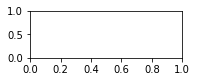

In [11]:
for i in range(len(learning_rates)):
    	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	train(learning_rates[i])
# show learning curves
pyplot.show()

In [1]:
!nvidia-smi

Wed May 19 20:17:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 25%   42C    P5    32W / 250W |      0MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
sys.path.append('/workspace/detect-me/product_classifier/')

In [14]:
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

In [ ]:
from models.basemodel import BaseModel
from utils import image_pp, data_loader

import os
import re
import pathlib
import json
import h5py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
from keras.models import Model
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
path_to_data = pathlib.Path("/workspace/detect-me/product_classifier/data/")
path_to_model=pathlib.Path("/workspace/detect-me/product_classifier/saved_models/",)

In [5]:
resnet_model = tf.keras.applications.ResNet50(
                             include_top=False,
                             weights="imagenet",
                             input_tensor=None,
                             # input_shape=(*self.image_size, 3),
                             pooling=None,
                             classes=1000)

In [27]:
image_size = 224,244
# name_tensorboard = name_tensorboard
model = None
info = None
validation_steps = 0
train_length = 0
steps_per_epoch = 0
cat = 'milk'
# optimizer = self.config.train.optimizer.type
batch_size = 32
epochs = 20
dropout =0.3
lr = 0.0001
fine_tune_at = 80

In [7]:
dataset = data_loader.load_data_flow_from_directory(
    path_to_data /cat/ 'train-val',
    path_to_data /cat/ 'test',
    target_image_size=image_size,
    batch_size=batch_size)

Found 9398 images belonging to 348 classes.
Found 2204 images belonging to 348 classes.
Found 328 images belonging to 348 classes.


In [8]:
# data and model
# self.num_classes = self.config.data.num_classes
# self.image_size = self.config.data.image_size

# path 
# self.path_to_data = (pathlib.Path(self.config.data.path_to_data) /
#                      self.cat)  # images folder separate by classes
# self.path_to_save_model = (pathlib.Path(self.config.data.path_to_model) /
#                       self.cat /
#                       self.base_model.name)  # save model history
# self.path_to_tensroboard_log = (pathlib.Path(self.config.data.path_to_model) /
#                       self.cat /
#                       'tensorboard_logs')

# print(f'model_path ::\n{path_to_save_model}')
# print(f'tensorboard_logs_path_ ::\n{self.path_to_tensroboard_log}')
# print(f'data_path_ ::\n{self.path_to_data}')
# print('init_done')


def data_augment(inputs):
    data_augmentation = keras.Sequential(
        [
            #                   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
            #                 tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
            # tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            # tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
            #                   tf.keras.layers.experimental.preprocessing.RandomZoom(0.4),
            # tf.keras.layers.experimental.preprocessing.RandomTranslation(
                # height_factor=0.2, width_factor=0.2),
            image_pp.RandomCutout((220, 40)),
            #           tf.keras.layers.experimental.preprocessing.RandomCrop(224,224,),
            #         tf.keras.layers.experimental.preprocessing.Rescaling(),
        ]
    )
    return data_augmentation(inputs)
    # plot_history %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

def plot_history(history,
                 save=False,
                 save_path='./train_validation.png'):
    print(history.history.keys)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 5.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    if save:
        plt.savefig(save_path, dpi=300)
        print('plot_saved')
        print('save_path\n', save_path)
    plt.show()

    return plt.gcf()

def load_data():
    dataset = data_loader.load_data_flow_from_directory(
        path_to_data / cat/ 'train-val',
        path_to_data /cat/  'test',
        target_image_size=image_size,
        batch_size=batch_size)

    # TODO remove it man! seriouslyy . I mean it. NOW!. . . .
    try:
        assert set(['train', 'test', 'samples', 'class_indices']).issubset(dataset.keys())
    except AssertionError:
        print('dictionary loaded from util/dataloader is different')
    return dataset

dataset = load_data()

num_classes = dataset['num_classes']

dataset.keys()

In [ ]:
def train(lr):
    inputs = tf.keras.Input(shape=(224, 224, 3))
# x = self.data_augment(inputs)
    x = preprocess_input(inputs)

    # As previously mentioned, use training=False as our model contains a BatchNormalization layer.
    x = resnet_model(x, training=False)

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    x = global_average_layer(x)

    x = tf.keras.layers.Dropout(dropout)(x)
    # x = tf.keras.layers.Dense(512, activation='relu')(x)
    # x = tf.keras.layers.Dropout(self.dropout)(x)
    # x = tf.keras.layers.Dense(512, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(num_classes//2, activation='relu')(x)

    prediction_layer = tf.keras.layers.Dense(
        num_classes, activation='softmax')

    outputs = prediction_layer(x)

    model = tf.keras.Model(inputs, outputs)
    
    resnet_model.trainable = True
    for layer in resnet_model.layers[:fine_tune_at]:
        layer.trainable = False

    print('len(self.model.trainable_variables) ',
          len(resnet_model.trainable_variables))

    optimizer = 'adam'
    print( optimizer.lower())
    if  optimizer.lower() == 'adam':
        optimizer=tf.keras.optimizers.Adam(lr=lr,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    amsgrad=False,
                                    name="Adam",)
    elif  optimizer.lower() == 'sgd':
        optimizer=tf.keras.optimizers.SGD(lr=lr,
                                    momentum=0.9,
                                     name="SGD")
    elif  optimizer.lower() == 'rmsprop':
        optimizer=tf.keras.optimizers.RMSprop(lr=lr,
                                    rho=0.9,
                                    momentum=0.0,
                                    epsilon=1e-07,
                                    centered=False,
                                    name="RMSprop")
    elif  optimizer.lower() == 'adadelta':
        optimizer=tf.keras.optimizers.Adadelta(
                                    learning_rate=lr,
                                    rho=0.95,
                                    epsilon=1e-07,
                                    name="Adadelta",
                                     )
    else:
        raise ValueError('optimizer s :: |.sgd.|.rmsprop.|.adam.|.adadelta.|]')

    # if  ob
    model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy',
                                #                       tf.keras.metrics.AUC(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),
                                # tfa.metrics.F1Score(num_classes=num_classes),
                                #   tf.keras.metrics.SparseCategoricalCrossentropy() #error
                                ],)
    print(['*']*100)
    print( model.optimizer.get_config())
    print(['*']*100)
    
    cbs= []
    lr_callback1 = ReduceLROnPlateau(
                        monitor='loss',
                        factor=0.1,
                        patience=3,
                        verbose=1,
                        mode='auto',
                        epsilon=0.0001,
                        cooldown=0,
                        min_lr=0)
    cbs.append(lr_callback1)
    history =  model.fit( dataset['train'],
                             batch_size= batch_size,
                             epochs=epochs,
                             validation_data= dataset['validation'],
                             callbacks=cbs,
                             verbose=1,
                             steps_per_epoch= dataset['samples'] //  batch_size,
                             workers=4,
                             )
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('lrate='+str(lr), pad=-50)
    return history

In [29]:
train(0.0008)

len(self.model.trainable_variables)  116
adam
['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
{'name': 'Adam', 'learning_rate': 0.0008, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*'

KeyboardInterrupt: 

len(self.model.trainable_variables)  152
adam
['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
{'name': 'Adam', 'learning_rate': 0.1, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
['*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '

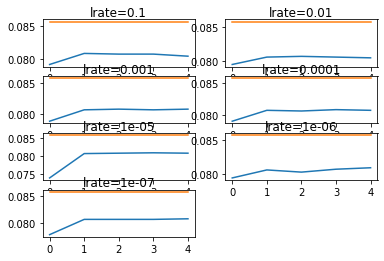

In [16]:


# create learning curves for different learning rates
learning_rates = [1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	train(learning_rates[i])
# show learning curves
pyplot.show()

In [8]:
# # train %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# def train(self,
#           save=False,
#           epochs=None,
#           save_name='no_name',
#           initial_epoch=0,
#           verbose=1,
#           add_callbacks=[]
#           ):

#     epochs = epochs if epochs else  epochs
#     cbs =  callbacks()
#     cbs.extend(add_callbacks)
#     print(f'callbacks ::{cbs}')
#     history =  model.fit( dataset['train'],
#                              batch_size= batch_size,
#                              epochs=epochs,
#                              initial_epoch=initial_epoch,
#                              validation_data= dataset['validation'],
#                              callbacks=cbs,
#                              verbose=verbose,
#                              steps_per_epoch= dataset['samples'] //  batch_size,
#                              workers=4,
#                              )

#     if save:
#         DIR =  path_to_save_model / save_name
#         if not os.path.exists(DIR):
#             os.makedirs(DIR)
#          model.save(DIR)
#         plot =  plot_history(history, save=True,
#                                  save_path=DIR / 'cross_val.png')
#         # TODO function history to pandas dataftame
#         mapping =  dataset['class_indices']
#         mapping = pd.DataFrame.from_dict(mapping, orient='index')
#         mapping.columns = ['code']
#         mapping.index.name = 'vms'
#         mapping.to_csv(DIR /'vms_code_mapping.csv')
#         print('saved')
#     else:
#         plot =  plot_history(history, save=False)

#     return history
#     # evaluate %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     def evaluate(self, test_data):
#          model.evaluate(
#             test_data,
#             batch_size=None,
#             verbose=1,
#             sample_weight=None,
#             steps=None,
#             callbacks=None,
#             max_queue_size=10,
#             workers=1,
#             use_multiprocessing=False,
#             return_dict=False,
#         )
#     # predict %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     def predict(self, image):
#         return  model.predict(image)
#     # callbacks %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#     @staticmethod
#     def lr_scheduler(epoch, lr):
#         if epoch < 10:
#             return lr
#         else:
#             return lr * tf.math.exp(-0.1)

#     def callbacks(self,):


#         lr_callback = LearningRateScheduler( lr_scheduler)

#         tensorboard_callback = tf.keras.callbacks.TensorBoard(
#                         log_dir=str( path_to_tensroboard_log/  name_tensorboard),
#                         histogram_freq=2,
#                         write_graph=False,
#                         write_images=True,
#                         update_freq="epoch",
#                         profile_batch=2,
#                         embeddings_freq=0,
#                         embeddings_metadata=None,)
#         save_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#                         str( path_to_save_model /
#                                 'checkpoints' /
#                                 f'{ name_tensorboard}' /
#                                 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'),
#                         monitor='val_loss',
#                         verbose=0,
#                         save_best_only=True,
#                         save_weights_only=False,
#                         mode='auto',
#                         save_freq='epoch',
#                         options=None)
#         return [
#             lr_callback,
#             tensorboard_callback,
#             # save_checkpoint_callback
#         ]

NameError: name 'BaseModel' is not defined